In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Kuzushiji-MNIST dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [6]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [7]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.8521525859832764
Epoch [2/5], Loss: 0.8579667806625366
Epoch [3/5], Loss: 0.8122833371162415
Epoch [4/5], Loss: 0.8020141124725342
Epoch [5/5], Loss: 0.799837589263916


In [10]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Partition

In [14]:
# cluster: 6, CLient: 10

In [15]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic Dataloaders

In [16]:
trainingset = train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 4

In [17]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=num_clients, alpha=alpha)

    # Normal loader classic
    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_strong, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_strong = []
    test_fashion(trial_model_strong,test_loader,test_losses_classic_strong)

    

    for round_idx in range(rounds_classic):
        
        print(f"Round {round_idx + 1}/{rounds_classic}")
    
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)


    ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    # Clustered loader classic
    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_classic = []
            for client_idx, client_model in enumerate(local_models_classic_strong[0:num_clusters]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_classic.append(client_weights)
                
        
            global_weights_classic = federated_averaging(local_weights_classic)
        
        
            distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
        
            distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
            test_losses = []
            test_fashion(global_model_classic_strong,test_loader,test_losses)
    
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data = data.view(data.shape[0], -1)
                    output = global_model_classic_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if alpha not in clusteredResults["classic"]:
                clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}
    
            clusteredResults["classic"][alpha]["losses"].extend(test_losses)
            clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313190
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.263790
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.273433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.262154
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.227571
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.154624
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.109187
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.105806
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.005012
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.941321
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.914680
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.741065
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.679722
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.644623
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.519399
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.513030
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.475740
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.342656
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.092968
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5566, Accuracy: 8308/10000 (83%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.305847
Train Epoch: 1 [640/8317 (8%)]	Loss: 1.798669
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.956713
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.534597
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.562684
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.498217
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.277649
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.346424
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.321074
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.565012
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.312193
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.222919
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.264177
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.301003
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.511633
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.393998
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.379987
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.122993
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.199158
Train Epoch: 2

In [18]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.9785472570419311, 1.5987298358917237, 1.3710020244598389, 1.2360537326812744], 'accuracy': [31.65, 48.03, 55.52, 60.05]}, 0.5: {'losses': [0.8445825098991394, 0.7603872406005859, 0.71299076795578, 0.6748884176254273], 'accuracy': [72.45, 75.35, 77.28, 78.79]}, 1: {'losses': [0.5841699821472168, 0.5613236526966094, 0.5428996605396271, 0.5356988211631775], 'accuracy': [81.91, 82.8, 83.64, 84.15]}, 5: {'losses': [0.4896132906913757, 0.49187680020332336, 0.47835396637916566, 0.4811594923973084], 'accuracy': [85.98, 85.91, 86.59, 86.77]}, 10: {'losses': [0.48043551831245424, 0.48000709929466245, 0.4762062647819519, 0.48379078583717344], 'accuracy': [87.23, 87.3, 87.68, 87.6]}, 20: {'losses': [0.49531668119430544, 0.4918854974746704, 0.49362526617050173, 0.4939912700176239], 'accuracy': [87.81, 87.96, 87.96, 87.91]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {0.1: {'losses': [1.2501355842590332, 1.2340

# PCA Dataloaders

In [20]:
# pca 
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()


In [ ]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)
    
    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

    # Pca strong
    optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)

    test_losses_pca_strong = []
    test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)

    rounds_pca = 4
    for round_idx in range(rounds_pca):
        
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)
    
        # Save results for non-clustered classic
        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}
    
        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_classic)

    ##############33
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]


    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_pca = []
            for client_idx, client_model in enumerate(local_models_pca_strong[0:num_clusters]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_pca.append(client_weights)
                
        
            global_weights_pca = federated_averaging(local_weights_pca)
        
            distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
        
            distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
            test_losses = []
            test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_pca:
                    data = data.view(data.shape[0], -1)
                    output = global_model_pca_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader_pca.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if alpha not in clusteredResults["pca"]:
                clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}
    
            clusteredResults["pca"][alpha]["losses"].extend(test_losses)
            clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_classic)
        

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.383692
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.151941
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.886116
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.739694
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.468896
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.356588
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.162342
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.099022
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.943056
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.017659
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.944069
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.763357
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.856798
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.897416
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.944250
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.707473
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.686907
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.726139
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.594535
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.

In [34]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.9785472570419311, 1.5987298358917237, 1.3710020244598389, 1.2360537326812744], 'accuracy': [31.65, 48.03, 55.52, 60.05]}, 0.5: {'losses': [0.8445825098991394, 0.7603872406005859, 0.71299076795578, 0.6748884176254273], 'accuracy': [72.45, 75.35, 77.28, 78.79]}, 1: {'losses': [0.5841699821472168, 0.5613236526966094, 0.5428996605396271, 0.5356988211631775], 'accuracy': [81.91, 82.8, 83.64, 84.15]}, 5: {'losses': [0.4896132906913757, 0.49187680020332336, 0.47835396637916566, 0.4811594923973084], 'accuracy': [85.98, 85.91, 86.59, 86.77]}, 10: {'losses': [0.48043551831245424, 0.48000709929466245, 0.4762062647819519, 0.48379078583717344], 'accuracy': [87.23, 87.3, 87.68, 87.6]}, 20: {'losses': [0.49531668119430544, 0.4918854974746704, 0.49362526617050173, 0.4939912700176239], 'accuracy': [87.81, 87.96, 87.96, 87.91]}}, 'pca': {0.1: {'losses': [2.0565093997955324, 1.7449555099487304, 1.5511906476974486, 1.4230282857894898], 'accura

# Autoencoder Dataloader

In [ ]:
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [29]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    # Normal loader autoencoder
    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

    # Auto strong
    optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

    test_losses_auto_strong = []
    test_fashion(trial_model_auto_strong,reduced_train_loader_auto,test_losses_auto_strong)

    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for non-clustered classic
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}
        
        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}
        
        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.174177
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.303681
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.400366
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.272631
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.292393
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.358684
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.353247
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.379752
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.414970
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.260995
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.207374
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.304130
Train Epoch: 2 [14720/60000 (25%)]	Loss: 0.334512
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.147340
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.379507
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.286168
Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.303632
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.322147
Train Epoch: 2 [18560/60000 (31%)]	Loss: 0.244134
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.210097
Train

In [30]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [1.9785472570419311, 1.5987298358917237, 1.3710020244598389, 1.2360537326812744], 'accuracy': [31.65, 48.03, 55.52, 60.05]}, 0.5: {'losses': [0.8445825098991394, 0.7603872406005859, 0.71299076795578, 0.6748884176254273], 'accuracy': [72.45, 75.35, 77.28, 78.79]}, 1: {'losses': [0.5841699821472168, 0.5613236526966094, 0.5428996605396271, 0.5356988211631775], 'accuracy': [81.91, 82.8, 83.64, 84.15]}, 5: {'losses': [0.4896132906913757, 0.49187680020332336, 0.47835396637916566, 0.4811594923973084], 'accuracy': [85.98, 85.91, 86.59, 86.77]}, 10: {'losses': [0.48043551831245424, 0.48000709929466245, 0.4762062647819519, 0.48379078583717344], 'accuracy': [87.23, 87.3, 87.68, 87.6]}, 20: {'losses': [0.49531668119430544, 0.4918854974746704, 0.49362526617050173, 0.4939912700176239], 'accuracy': [87.81, 87.96, 87.96, 87.91]}}, 'pca': {0.1: {'losses': [2.0565093997955324, 1.7449555099487304, 1.5511906476974486, 1.4230282857894898], 'accura

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 1.5460832125186919, 0.5: 0.7482122340202332, 1: 0.5560230291366577, 5: 0.48525088741779326, 10: 0.48010991705656053, 20: 0.49370467871427537}
  Average Accuracy: {0.1: 48.8125, 0.5: 75.9675, 1: 83.125, 5: 86.3125, 10: 87.45250000000001, 20: 87.91}
pca:
  Average Loss: {0.1: 1.6939209608078003, 0.5: 0.9499942564487457, 1: 0.6956806065797806, 5: 0.5631076457738876, 10: 0.48903468499183655, 20: 0.44167271597385405}
  Average Accuracy: {0.1: 59.72749999999999, 0.5: 82.63749999999999, 1: 87.15, 5: 89.07, 10: 89.875, 20: 89.9475}
autoencoder:
  Average Loss: {0.1: 2.0911009833812715, 0.5: 3.3438766254425047, 1: 6.042168612861634, 5: 9.002785079956055, 10: 12.405099291992187, 20: 15.82844169845581}
  Average Accuracy: {0.1: 28.985, 0.5: 37.5375, 1: 38.125, 5: 35.8825, 10: 32.575, 20: 30.66}


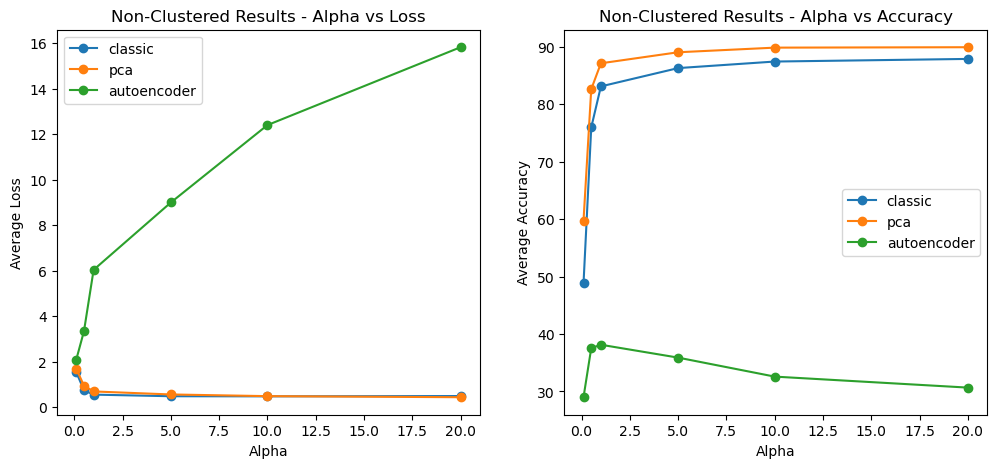


Clustered Results:
classic:
  Average Loss: {0.1: 1.2138830632686615, 0.5: 0.6500998563170434, 1: 0.5440736546158791, 5: 0.48602933163642886, 10: 0.4964337312936783, 20: 0.5158072104692459}
  Average Accuracy: {0.1: 63.480000000000004, 0.5: 80.025, 1: 84.295, 5: 86.9625, 10: 87.54, 20: 87.82249999999999}
pca:
  Average Loss: {0.1: 1.2600891228675841, 0.5: 0.7887110587596894, 1: 0.6330362161159515, 5: 0.5210627842426301, 10: 0.46099219330549246, 20: 0.4235551531672478}
  Average Accuracy: {0.1: 70.0075, 0.5: 85.3275, 1: 87.625, 5: 89.36, 10: 89.9125, 20: 90.10249999999999}
autoencoder:
  Average Loss: {0.1: 2.2819824221134186, 0.5: 5.004850791168213, 1: 7.470203602981567, 5: 10.935232984542846, 10: 14.262776205825807, 20: 17.484320491790772}
  Average Accuracy: {0.1: 34.565, 0.5: 37.724999999999994, 1: 37.2575, 5: 33.6275, 10: 31.4525, 20: 29.909999999999997}


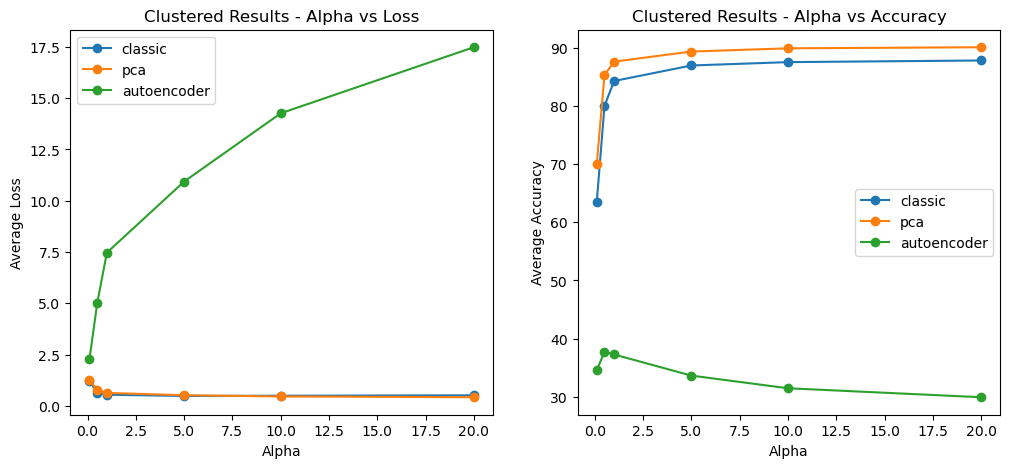

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    #plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")